In [1]:
# Importing all the dependencies
%load_ext autoreload
%autoreload 2

# Check if running in Colab
in_colab = True

import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('StudentsPerformance.csv')
gender_encoder = LabelEncoder()
test_preparation_encoder = LabelEncoder()
race_ethnicity_encoder = LabelEncoder()
parental_education_encoder = LabelEncoder()
lunch_encoder = LabelEncoder()

df['gender_encoded'] = gender_encoder.fit_transform(df['gender'])
df['test_preparation_encoded'] = test_preparation_encoder.fit_transform(df['test preparation course'])
df['race_ethnicity_encoded'] = race_ethnicity_encoder.fit_transform(df['race/ethnicity'])
df['parental_education_encoded'] = parental_education_encoder.fit_transform(df['parental level of education'])
df['lunch_encoded'] = lunch_encoder.fit_transform(df['lunch'])

df = df.drop(columns=['gender', 'test preparation course', 'race/ethnicity', 'parental level of education', 'lunch'])

In [5]:
x = df.drop(['math score', 'reading score','writing score'], axis=1)
y = df[['math score', 'reading score','writing score']]

# **Random forest**

In [6]:
param_grid_rfg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [7]:
rfg_model = RandomForestRegressor()
grid_search_rfg = GridSearchCV(estimator=rfg_model, param_grid=param_grid_rfg, cv=5, n_jobs=-1, scoring='r2')

In [8]:
grid_search_rfg.fit(x, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [10]:
best_estimator_rfg = grid_search_rfg.best_estimator_
best_estimator_rfg

RandomForestRegressor(max_depth=30, max_features='log2', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=200)

In [11]:
def rfg(best_estimator, X, Y):
  rfg_r2_train = []
  rfg_r2_test = []
  rfg_mae = []
  folds = 4
  kf = KFold(n_splits=folds)
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    Y_train_pred = best_estimator.predict(X_train)
    Y_test_pred = best_estimator.predict(X_test)

    train_r2 = r2_score(Y_train, Y_train_pred)
    test_r2 = r2_score(Y_test, Y_test_pred)

    rfg_r2_train.append(train_r2)
    rfg_r2_test.append(test_r2)
    rfg_mae.append(mean_absolute_error(Y_test, Y_test_pred))

  r2_train_avg = (sum(rfg_r2_train)/len(rfg_r2_train))
  r2_test_avg = (sum(rfg_r2_test)/len(rfg_r2_test))
  mae_avg = (sum(rfg_mae)/len(rfg_mae))

  print(f'R2 Train = {rfg_r2_train}')
  print(f'R2 Test = {rfg_r2_test}')
  print(f'MAE = {rfg_mae}')
  print(f'R2 Train Promedio = {r2_train_avg}')
  print(f'R2 Test Promedio = {r2_test_avg}')
  print(f'MAE Promedio = {mae_avg}')

In [12]:
resultados_rfg = rfg(best_estimator_rfg, x, y)
resultados_rfg

R2 Train = [0.3249392295365003, 0.3304572163463894, 0.34302751900992945, 0.34492319945748734]
R2 Test = [0.3601345629339907, 0.3551067936713797, 0.3090800705302532, 0.30898863313851377]
MAE = [10.054546320856538, 9.203645749184561, 9.801495030331354, 10.033103606271347]
R2 Train Promedio = 0.33583679108757664
R2 Test Promedio = 0.3333275150685343
MAE Promedio = 9.77319767666095


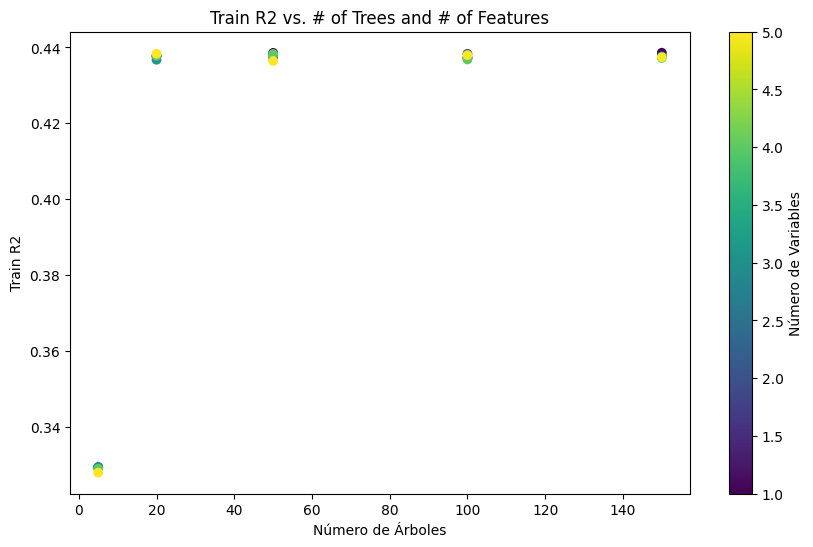

In [ ]:
num_trees = resultados_rf['número de árboles']
num_variables = resultados_rf['numero de variables']
train_rmse = resultados_rf['train R2']

# Create a 2D plot for train RMSE
plt.figure(figsize=(10, 6))
plt.scatter(num_trees, train_rmse, c=num_variables, cmap='viridis')
plt.colorbar(label='Número de Variables')
plt.xlabel('Número de Árboles')
plt.ylabel('Train R2')
plt.title('Train R2 vs. # of Trees and # of Features')
plt.show()

#**Gradient Boosting**

In [13]:
param_grid_gbt = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 4, 5],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

In [14]:
gbt_model = MultiOutputRegressor(GradientBoostingRegressor())
grid_search_gbt = GridSearchCV(estimator=gbt_model, param_grid=param_grid_gbt, cv=5, scoring='r2')

In [15]:
grid_search_gbt.fit(x, y)
best_estimator_gbt = grid_search_gbt.best_estimator_
best_estimator_gbt

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                         max_features='log2',
                                                         min_samples_leaf=4,
                                                         min_samples_split=5,
                                                         n_estimators=300))

In [9]:
best_estimator_gbt = grid_search_gbt.best_estimator_
best_estimator_gbt

NameError: ignored

In [16]:
def gbt(best_estimator, X, Y):
  gbt_r2_train = []
  gbt_r2_test = []
  gbt_mae = []
  folds = 4
  kf = KFold(n_splits=folds)
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    Y_train_pred = best_estimator.predict(X_train)
    Y_test_pred = best_estimator.predict(X_test)

    train_r2 = r2_score(Y_train, Y_train_pred)
    test_r2 = r2_score(Y_test, Y_test_pred)

    gbt_r2_train.append(train_r2)
    gbt_r2_test.append(test_r2)
    gbt_mae.append(mean_absolute_error(Y_test, Y_test_pred))

  r2_train_avg = (sum(gbt_r2_train)/len(gbt_r2_train))
  r2_test_avg = (sum(gbt_r2_test)/len(gbt_r2_test))
  mae_avg = (sum(gbt_mae)/len(gbt_mae))

  print(f'R2 Train = {gbt_r2_train}')
  print(f'R2 Test = {gbt_r2_test}')
  print(f'MAE = {gbt_mae}')
  print(f'R2 Train Promedio = {r2_train_avg}')
  print(f'R2 Test Promedio = {r2_test_avg}')
  print(f'MAE Promedio = {mae_avg}')

In [17]:
resultados_gbt = gbt(best_estimator_rfg, x, y)
resultados_gbt

R2 Train = [0.3249392295365003, 0.3304572163463894, 0.34302751900992945, 0.34492319945748734]
R2 Test = [0.3601345629339907, 0.3551067936713797, 0.3090800705302532, 0.30898863313851377]
MAE = [10.054546320856538, 9.203645749184561, 9.801495030331354, 10.033103606271347]
R2 Train Promedio = 0.33583679108757664
R2 Test Promedio = 0.3333275150685343
MAE Promedio = 9.77319767666095


# Redes neuronales artificiales

In [18]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 100, 100), (50, 100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 300],
    'early_stopping': [True, False],
}

In [19]:
mlp_model = MLPRegressor()

grid_search_ann = GridSearchCV(estimator=mlp_model, param_grid=param_grid_mlp, scoring='r2', cv=5, n_jobs=-1)

In [ ]:
grid_search_ann.fit(x,y)
best_estimator_ann = grid_search_ann.best_estimator_
best_estimator_ann